## Import and Set up

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

RANDOM_STATE = 42

pairs = pd.read_csv("../data/processed/pairs.csv")
emb = np.load("../data/processed/embeddings.npy")

pairs.head()


,idx1,idx2,same
0,889,722,0
1,5451,10884,0
2,4262,7558,0
3,10319,241,1
4,7449,880,1


## Feature engineering

We combine four standard verification features:
- |e1 − e2|
- e1 * e2
- cosine similarity
- L2 distance

In [3]:
e1 = emb[pairs.idx1.values]
e2 = emb[pairs.idx2.values]

abs_diff = np.abs(e1 - e2)
prod = e1 * e2
cos_sim = np.sum(e1 * e2, axis=1, keepdims=True)
l2_dist = np.linalg.norm(e1 - e2, axis=1, keepdims=True)

X = np.hstack([abs_diff, prod, cos_sim, l2_dist])
y = pairs.same.values

print("Feature matrix:", X.shape)

Feature matrix: (16800, 1026)


## Train/validation split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)


## SVM + hyperparameter tuning

In [5]:
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.01, 0.001]
}

grid = GridSearchCV(
    SVC(
        kernel="rbf",
        probability=True,
        random_state=RANDOM_STATE
    ),
    param_grid,
    scoring="roc_auc",
    cv=3,          # SVM is slower than LR
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

model = grid.best_estimator_
print("Best params:", grid.best_params_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params: {'C': 10, 'gamma': 'scale'}


## Evaluation

In [6]:
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

print("Accuracy :", accuracy_score(y_val, y_pred))
print("F1 score :", f1_score(y_val, y_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_prob))


Accuracy : 0.9875
F1 score : 0.9875444839857651
ROC AUC  : 0.997674319727891


## ROC Curve

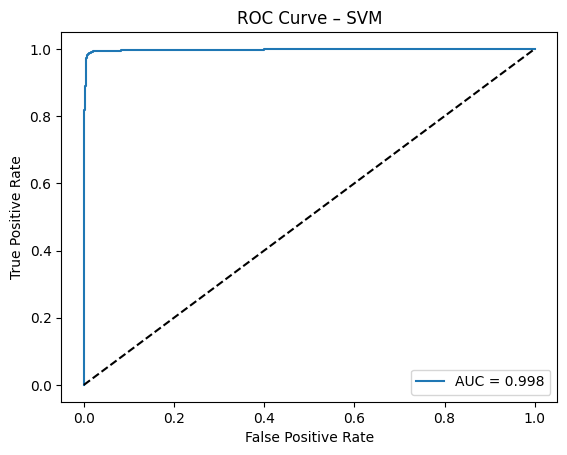

In [7]:
fpr, tpr, _ = roc_curve(y_val, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_val, y_prob):.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – SVM")
plt.legend()
plt.show()
